# Assignment 6: Reinforcement Learning
Use Reinforcement learning to train an agent that can successfully move the cartpole to the left using OpenAI Gym’s CartPole environment.

In [1]:
#import all necessary libraries
import sys
from packaging import version
import tensorflow as tf
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import gym

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Configure matplotlib settings for plots and animations
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

# Set up a path for saving images
IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# Function to save a figure as an image
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Create a CartPole-v1 environment with RGB rendering
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [3]:
# extra code – shows the first few environments
envs = gym.envs.registry
sorted(envs.keys())[:5] + ["..."]

['Acrobot-v1', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'BipedalWalker-v3', '...']

In [4]:
# Display the specification for the CartPole-v1 environment
print(envs["CartPole-v1"])

EnvSpec(id='CartPole-v1', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1)


In [5]:
# Reset the environment and get the initial observation and info
obs, info = env.reset(seed=42)
print("Observation:", obs)
print("Info:", info)

Observation: [ 0.0273956  -0.00611216  0.03585979  0.0197368 ]
Info: {}


In [6]:
# Render the environment and display it
img = env.render()
print("Image shape:", img.shape)

Image shape: (400, 600, 3)


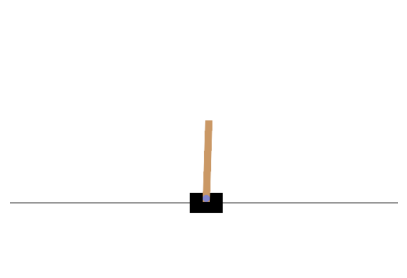

In [7]:
# Function to plot and render an environment
def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

# Display the environment using the plot_environment function
plot_environment(env)
plt.show()

In [8]:
# Display the action space of the environment
print("Action Space:", env.action_space)

Action Space: Discrete(2)


In [9]:
action = 0  # accelerate right 1 and left 0
obs, reward, done, truncated, info = env.step(action)
print("Observation after taking action:", obs)
print("Reward:", reward)
print("Done:", done)
print("Truncated:", truncated)
print("Info:", info)

Observation after taking action: [ 0.02727336 -0.20172954  0.03625453  0.32351476]
Reward: 1.0
Done: False
Truncated: False
Info: {}


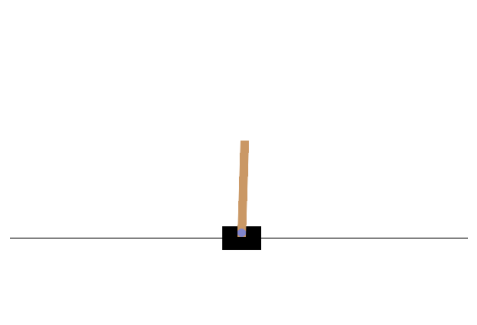

In [10]:
# Display the environment after taking an action
plot_environment(env)
save_fig("cart_pole_plot")
plt.show()

In [11]:
# Check if the episode is done or truncated and reset if necessary
if done or truncated:
    obs, info = env.reset()

In [12]:
# Function to update the animation scene
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

# Function to create an animation of an episode
def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

# Function to show an episode using a policy
def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            obs, info = env.reset()
            break
    env.close()
    return plot_animation(frames)

# 1. Using Neural Network Policy to move the CartPole to left direction

In [13]:
# Set a random seed for reproducibility (CPU)
tf.random.set_seed(42)

# Define a simple neural network policy
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

# Function for the neural policy to decide the action
def neural_policy(obs):
    left_proba = model.predict(obs[np.newaxis], verbose=0)
    return int(np.random.rand() > left_proba)

np.random.seed(42)
show_one_episode(neural_policy)

# 2. Implement the Policy Gradient algorithm to the above scenario

In [14]:
# Function to choose action based on policy model
def policy_gradient(obs):
    left_proba = model_pg.predict(obs[np.newaxis], verbose=0)
    
    return int(np.random.rand() > left_proba) # Change from ">" to "<" to go to left

np.random.seed(42)

In [15]:
# Function to play one step using the model and return the gradients
def play_one_step(env, obs, model_pg, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model_pg(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba).numpy()
        
        # Update the target label to encourage moving left
        target_label_left = tf.constant([[1.]])
        y_target = target_label_left - tf.cast(action, tf.float32)
        
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model_pg.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    
    # Adjust the reward based on the desired behavior (moving left)
    if action == 0:  # Action 0 corresponds to moving left
        reward += 2  # Positive reward for moving left

    return obs, reward, done, truncated, grads


In [16]:
# Function to play multiple episodes, collecting rewards and gradients
def play_multiple_episodes(env, n_episodes, n_max_steps, model_pg, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model_pg, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                obs, info = env.reset()
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

In [17]:
# Function to discount rewards over time
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [18]:
# Training parameters
n_iterations = 180
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

# Neural network model for policy approximation
tf.random.set_seed(42)
model_pg = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy
# Target label for moving left is 1, for moving right is 0
target_label_left = np.array([[1]])

# Environment setup
obs, info = env.reset(seed=42)


In [19]:
# Training loop
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model_pg, loss_fn)

    # Calculate total rewards and display progress
    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")

     # Normalize rewards and compute mean gradients
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model_pg.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
        
    # Apply gradients to the model
    optimizer.apply_gradients(zip(all_mean_grads, model_pg.trainable_variables))


Iteration: 180/180, mean rewards: 354.7

In [20]:
# Show an episode using the trained neural policy
np.random.seed(42)
show_one_episode(policy_gradient)


# 3. Implement Markov Decision Process defining the random transition probabilities, rewards and possible actions to move the CartPole towards left

In [21]:
# Discretize the state space
def discretize_state(obs):
    # Simplified discretization: consider only the position and velocity of the cart
    cart_pos, cart_vel, pole_angle, pole_vel = obs
    return (round(cart_pos, 1), round(cart_vel, 1))

In [22]:
# Define the MDP model
class CartPoleMDP:
    def __init__(self):
        self.actions = [0, 1]  # 0: left, 1: right
        self.state_transition = {}  # Transition probabilities
        self.rewards = {}  # Rewards

    def get_next_state(self, current_state, action):
        # Simplified transition model
        # In reality, this would be based on the physics of the CartPole
        next_state = (current_state[0] + (0.1 if action == 1 else -0.1), current_state[1])
        return next_state

    def get_reward(self, current_state, action):
        # Higher reward for moving left or staying still
        return 1 if action == 0 else 0

    def step(self, current_state, action):
        next_state = self.get_next_state(current_state, action)
        reward = self.get_reward(current_state, action)
        return next_state, reward

# Implement the MDP policy
def mdp_policy(state, mdp_model):
    # Simple policy: always move left
    return 0  # Action 0 corresponds to moving left

In [23]:
# Function to show an episode using the MDP policy
def show_mdp(policy, mdp_model, env, n_steps=200):
    frames = []
    obs, info = env.reset()
    for _ in range(n_steps):
        frames.append(env.render())
        state = discretize_state(obs)
        action = policy(state, mdp_model)
        obs, reward, done, truncated, _ = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)



In [24]:
# Create the CartPole environment and MDP model
env = gym.make("CartPole-v1", render_mode="rgb_array")
mdp_model = CartPoleMDP()

# Visualize the CartPole using the MDP policy
np.random.seed(42)
show_mdp(mdp_policy, mdp_model, env)

# 4. Implement Deep Q Learning (Epsilon Greedy Policy) to move the CartPole towards left

In [25]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

input_shape = [4]  # == env.observation_space.shape
n_outputs = 2  # == env.action_space.n

model_dq = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])


optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error


def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # random action
    else:
        Q_values = model_dq.predict(state[np.newaxis], verbose=0)[0]
        return np.argmax(Q_values)  # optimal action according to the DQN

from collections import deque

replay_buffer = deque(maxlen=2000)

# extra code – A basic circular buffer implementation

class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]
    
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds]


In [26]:
def play_one_step_dq(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)

        
    next_state, reward, done, truncated, info = env.step(action)
   
     # Adjust the reward based on the desired behavior (moving left)
    if action == 0:  # Action 0, corresponds to moving left
        reward += 2  # Positive reward for moving left
    else:
        reward -= 1
        
    replay_buffer.append((state, action, reward, next_state, done, truncated))
        
    return next_state, reward, done, truncated, info


In [27]:
# extra code – for reproducibility, and to generate the next figure
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
best_score = 0


In [28]:
batch_size = 32
discount_factor = 0.99

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model_dq.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model_dq(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model_dq.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_dq.trainable_variables))
    


In [35]:
# Training loop
for episode in range(350):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step_dq(env, obs, epsilon)
        if done or truncated:
            
            break

    # extra code – displays debug info, stores data for the next figure, and
    #              keeps track of the best model weights so far
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model_dq.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)

model_dq.set_weights(best_weights)  # extra code – restores the best model weights


Episode: 350, Steps: 138, eps: 0.302

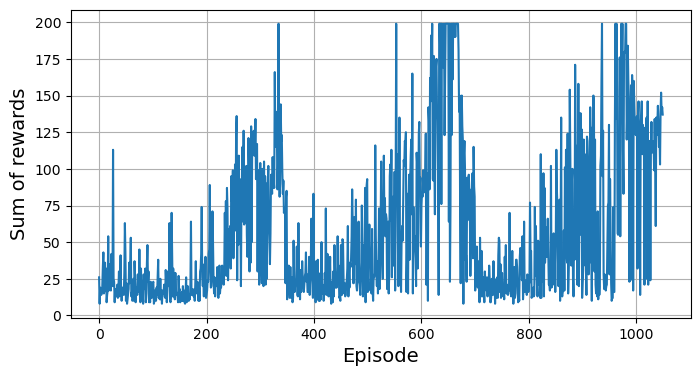

In [36]:
# extra code – this cell generates and saves Figure 18–10
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
#save_fig("dqn_rewards_plot")
plt.show()


In [34]:
# shows an animation of the trained DQN playing one episode
show_one_episode(epsilon_greedy_policy)